# **Block 1. Connection with Google Drive**

In [1]:
#Give access to Google Drive (access to data)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Block 2. Import libraries**

In [2]:
#Import the require libraries

import numpy as np #To be able to perform numerical operations

import torch ## Main PyTorch library for tensor computations and building neural networks
import torch.nn as nn #PyTorch's neural network module
from torch.utils.data import Dataset #It will serve as an interface for our data (Initialize and customize our dataset)
from torch.utils.data import DataLoader  #Manage data for training
from torch.nn.functional import one_hot #Convert labels to one-hot tensors
from torch import tensor #Create PyTorch tensors from existing data, such as lists or NumPy arrays.

import os #To interact with files
from PIL import Image # Allows us to open, manipulate and show images
from pathlib import Path #Work with routes more easily
import matplotlib.pyplot as plt #To plot

from sklearn.manifold import TSNE #For dimensionality reduction and visualization of high-dimensional data
#import plotly.graph_objs as go #For creating interactive plots
import plotly.express as px #For creating easy-to-use interactive plots

import torchvision #Import the library for working with datasets and pre-trained CNN model
from torch.nn import Conv2d,Linear,CrossEntropyLoss # Tools for building CNNs (layers and loss function)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay #Metrics for evaluating model performance
from collections import OrderedDict #Maintains the order of elements as they are added

# **Block 3. Creation of a class for our image dataset using Dataset**

In [3]:
#Define a class for our image dataset
class CustomImageTestDataset(Dataset): #The class we create will inherit the "Dataset" class that was imported (a class from PyTorch).
### METHOD 1: Initializer###  clase=class
    def __init__(self, dir_data): #With "dir_data" I receive the directory where our set is
        listt = os.listdir(dir_data) #I obtained a list of the files and directories in the variable "dir_data"
        print(listt) #I printed that list (classes' carpets)
        self.input_images_path = [] #An empty list is initialized to store the image paths
        self.class_labels = np.zeros((0,1)) #(Images labels) A 0 rows,1 column matrix filled with zeros is created (This is because I will need to apply operations with NumPy later)

        #This part is required for the 3D graphics
        self.class_names = {}  # An empty dictionary is initialized to map indexes to class names
        #This part is required for the 3D graphics

        for idx, folder_path in enumerate(listt): #This creates a tuple containing the id (0,1,2,3) and the archive or element (classes'carpets) and saves it in the variables
            current_image_paths = [p for p in Path(dir_data, folder_path).iterdir() if p.suffix in {'.jpg'}]#(a list of image paths) It's a loop that iterates through a directory list,
                                                                        #with the condition that the files have a .jpg extension. Those that meet this condition will be saved to the list.
            self.input_images_path += current_image_paths #(Image routes) The obtainded paths are added
            self.class_labels = np.vstack((self.class_labels, idx * np.ones((len(current_image_paths), 1))))#(Images labeling) A 0x1 matrix is vertically stacked with a matrix of total data X1, where
                                                                                              #each element is an index. [0,0,1,1,1,2,3,0..] in vertical. [A numpy array= a matrix]

            #This part is required for the 3D graphics
            self.class_names[idx] = folder_path  #Indices are related to class names
            #This part is required for the 3D graphics

        self.num_classes = len(np.unique(self.class_labels))#Calculates the number of unique classes from the image labels: [0,1,1,2,3] ->[0,1,2,3]=4
### METHOD 2: Obtain the length of the dataset ###
    def __len__(self):
        return len(self.input_images_path)#Counts the total images routes (Total images)

### METHOD 3:Access and modify elements ###
    def __getitem__(self, idx): #Receives an "idx" to return the exact element in the dataset.
        route = self.input_images_path[idx] #Returns the path of the image with the specified "idx."
        class_labels = self.class_labels[idx] #Save the image labels

        class_labels = tensor(class_labels).long()#Convert to a tensor and change to a long data type (numpy array -> tensor)
        class_labels = one_hot(class_labels, num_classes= self.num_classes).permute(1,0)#Convert every label image into a one-hot vector of size 4x1.

        #self.class_labels2 = class_labels # For TESTS (to view the one-hot vector)**

        img = Image.open(route)#Open the image using the specified path (route)
        img_resize = img.resize((224,224)) #Resize the image

        img_resize = np.array(img_resize)#Image is converted into a numpy array

        img_resize = np.moveaxis(img_resize, 2, 0)#The order of the array dimensions is changed because the image is required in the [C, H, W] format
                                                  #and PIL opens it as [H, W, C]

        img_resize = tensor(img_resize.astype(np.float32)).float()#Convert the image to a float tensor to preserve information and ensure compatibility
                                                                  #with PyTorch

        return  img_resize, class_labels #returns two tensors: one containing the image and another containing the image labels in one-hot format

**Sub-block 1. Create the object with our class**

In [9]:
test_dataset=CustomImageTestDataset('/content/drive/MyDrive/DATASET 3.1/Skin cancer ISIC The International Skin Imaging Collaboration/Test')#Create an object of the class

['seborrheic keratosis', 'squamous cell carcinoma', 'melanoma', 'nevus']


**Sub-block 2. Create the object dataloader**

In [10]:
test_dataloader = DataLoader(Test_dataset,batch_size=15,shuffle=True,num_workers=0)
# with reduced dataset batch of 17 and with the normal batch of 52

**Sub-block 3. Verify dataset length**

In [11]:
print(test_dataset.__len__())

285


## **Block 4. Extract features for 3D visualization**

In [12]:
def extract_features(dataloader): #Function to extract features/parameters to plot from a dataloader
    features = [] #Empty list where the features will go
    labels = [] #Empty list where the labels will go
    for batch in dataloader: #Loop in dataloader batches
        imgs, batch_labels = batch #The batches are unpacked
        imgs = imgs.to(device)#Transfer image data to the designated compute device for optimized processing
        batch_features = imgs.reshape(imgs.size(0), -1)#The image is flattened to a one-dimensional vector to obtain its characteristics
        features.append(batch_features.cpu().numpy())#They are added to cpu because it works with a numpy array
        labels.append(batch_labels.argmax(dim=1).cpu().numpy())#They are added to cpu because it works with a numpy array and returns the index of the most probable label
    return np.concatenate(features), np.concatenate(labels)#concatenated lists of features and labels are returned

## **Block 5. Plot in 3D**

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Characteristics extraction
features, labels = extract_features(test_dataloader)

#T-SNE applicattion
print("Applying t-SNE...")
tsne = TSNE(n_components=3, random_state=42, n_jobs=-1)  #n_jobs=-1 to use all cores
embeddings = tsne.fit_transform(features)

# Convert numeric labels to class names
label_names = [test_dataset.class_names[label[0]] for label in labels]

# Create interactive visualization with Plotly
print("Generating interactive visualization...")
fig = px.scatter_3d(
    x=embeddings[:, 0],
    y=embeddings[:, 1],
    z=embeddings[:, 2],
    color=label_names, #flatten is used because one dimension is required, and it was [841, 1]
    title='3D t-SNE visualization of the images',
    labels={'color': 'Class'},
    opacity=0.7
)

# Adjust the design
fig.update_layout(
    scene = dict(
        xaxis_title='t-SNE X',
        yaxis_title='t-SNE Y',
        zaxis_title='t-SNE Z'
    ),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

# Show the figure
fig.show()

Using device: cuda
Applying t-SNE...
Generating interactive visualization...


## **Block 6. Define the pre-trained model: Resnet152 (Teacher Model)**

In [15]:
def load_teacher_model(model_path, device = 'cuda' if torch.cuda.is_available() else 'cpu'): #define the method that loads the teacher model (the folder and the device where it will be loaded)
    # Load the model (learned parameters) into the 'state_dict'
    state_dict = torch.load(model_path) #Learned parameters

    # Determines the number of input channels and output classes
    n_channels_input = state_dict[list(state_dict.keys())[0]].size(1) #Is the first tensor and '.size(1)' return the channels of the tensor, which are in the second position
    n_classes = state_dict[list(state_dict.keys())[-1]].size(0)# Is the last the last tensor and size(0)return the classes, wich are in the first position

    #The teacher model is loaded RESNET152
    teacher_model = torchvision.models.resnet152()

    #Adjust the first convolutional layer to the number of input channels
    teacher_model.conv1 = Conv2d(n_channels_input, 64, kernel_size=(7, 7), stride=(2, 2))

    #Adjust the fully connected layer to the number of output classes
    teacher_model.fc = Linear(in_features=2048, out_features= n_classes)

    #Move the model to the appropriate device (CPU or GPU)
    teacher_model.to(device= device)

    #The 'state_dict' attribute, which contains the parameters of the previously trained model (the saved model), is loaded into the instance of the loaded model architecture
    try:
        teacher_model.load_state_dict(state_dict) #In teacher_model, the state_dict is loaded
    except:
      #If there is a module. prefix, we remove it
        new_state_dict = OrderedDict() #It is sorted
        for k, v in state_dict.items(): #The names and values are stored
            name = k[10:] # remove `module.`
            new_state_dict[name] = v
      # load params
        teacher_model.load_state_dict(new_state_dict)

    return teacher_model

## **Block 7. Define the pre-trained model: EfficientNet-b0 (Student Model)**



In [14]:
def load_stud_model(model_path, device = 'cuda' if torch.cuda.is_available() else 'cpu'): #define the method that loads the student model (the folder and the device where it will be loaded)
    #Load the model (learned parameters) into the 'state_dict'
    state_dict = torch.load(model_path)

    #Determines the number of input channels and output classes
    n_channels_input = state_dict[list(state_dict.keys())[0]].size(1) #Is the first tensor and '.size(1)' return the channels of the tensor, which are in the second position
    n_classes = state_dict[list(state_dict.keys())[-1]].size(0) #Is the last the last tensor and size(0)return the classes, wich are in the first position

    #The student model is loaded: EfficientNetb0
    student_model = torchvision.models.efficientnet_b0()

    #Adjust the first layer to the number of input channels
    student_model.features[0][0] = Conv2d(n_channels_input, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

    #Adjust the last layer to the number of output classes
    student_model.classifier[1] = Linear(in_features=1280, out_features= n_classes)

    #Move the model to the appropriate device (CPU or GPU)
    student_model.to(device= device)

    #The 'state_dict' attribute, which contains the parameters of the previously trained model (the saved model), is loaded into the instance of the loaded model architecture
    try:
        student_model.load_state_dict(state_dict) #In student_model, the state_dict is loaded
    except:
    #If there is a module. prefix, we remove it
        new_state_dict = OrderedDict() #It is sorted
        for k, v in state_dict.items():
            name = k[10:] # remove `module.`
            new_state_dict[name] = v
        # load params
        student_model.load_state_dict(new_state_dict)

    return student_model

### **Sub-block 4. Load the pre-trained models**

In [19]:
teacher = load_teacher_model('/content/drive/MyDrive/S.M.RESNET152SinWeights-D3.1-D.A/Modelo_epoch_28_val_loss_0.49938366342045887.pth')
student = load_stud_model('/content/drive/MyDrive/S.M-ModelDistillationD3.1/Resnet152-efficientb0/Modelo_epoch_25_val_loss_0.32993508704160573.pth')
#student = load_stud_model('/content/drive/MyDrive/S.M-MobileV2SinWeights-D3.1-D.A/30epocas/Modelo_epoch_20_val_loss_0.4078884457101193.pth')

<ipython-input-15-f79c915145d8>:3: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



# **Block 8. Test function**

In [20]:
def test_model(model, validation_loader, device):#The function is created (with some input parameters)
    model.eval() #set the model in evaluation mode
    all_true_labels = [] #Empty list to which data will be added (true labels)
    all_pred_labels = [] #Empty list to which data will be added (predicted labels)

    with torch.no_grad():  #Disable gradient calculations during evaluation
        for batch in validation_loader:#Each DataLoader has batches (validation_loader=dataloader), and we iterate over those batches
            imgs, targets = batch #Getting imgs and target output for current batch

            imgs = imgs.to(device= device, dtype = torch.float32)# (Tensor) Move to the device and ensure the tensor is in the correct format
            targets = targets.to(device= device, dtype = torch.float32)# (Tensor of 4,4,1) Move to the device and ensure the tensor is in the correct format - son las etiquetas [4,4]
            #print("Targets1:",targets.size())#FOR TEST
            network_output = model(imgs) #(Predictions) Apply the model to the input images [4,4]

            true_label = torch.argmax(targets, dim=1).cpu().numpy()#The position of the classes (max value of tensor) for all images is selected, transferred to the CPU, and
                                                                  #converted into a NumPy array (later it will be necessary to use operations with NumPy arrays)
            pred_label = torch.argmax(network_output, dim=1).cpu().numpy() #Both (true and pred) have a size of [4,1]

            #print("size true:",true_label.shape)#FOR TEST
            #print("size pred:",pred_label.shape)#FOR TEST

            #The arrays are modified to a one dimension [n,] instead of two [n,1], necessary to work with confusion matrix
            true_label = true_label.flatten()
            pred_label = pred_label.flatten()
            #valor_prediccionT=torch.unsqueeze(valor_prediccion, dim = -1)

            #The labels are concatenated in an individual list
            all_true_labels.extend(true_label)
            all_pred_labels.extend(pred_label)

        print("Size of True label:", true_label.shape)
        print("Size of Prediction label:", pred_label.shape)
        #aqui tenemos los valores que nos indican si es acertada o no la prediccion

        #Create the confusion matrix
        cm = confusion_matrix(all_true_labels, all_pred_labels)#Use the true labels and the predictions
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)#Creates the object
        disp.plot()#Prepare the figure
        plt.show()#Show the figure

        # Calculate and show the classification report and accuracy score
        report = classification_report(all_true_labels, all_pred_labels)
        accuracy = accuracy_score(all_true_labels, all_pred_labels)

        print("Classification report:\n", report)
        print("Accuracy Score:", accuracy)


    return all_true_labels, all_pred_labels

# **Block 9. Run Test**

Size of True label: (15,)
Size of Prediction label: (15,)


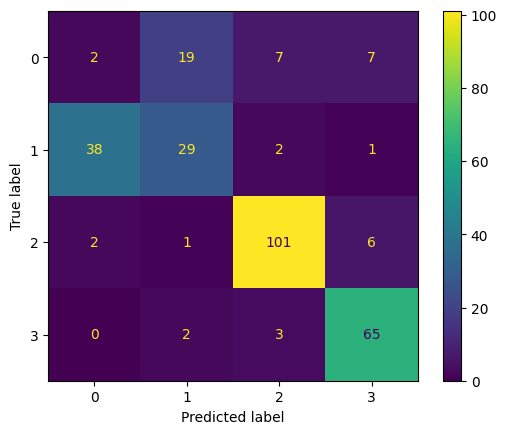

Classification report:
               precision    recall  f1-score   support

           0       0.05      0.06      0.05        35
           1       0.57      0.41      0.48        70
           2       0.89      0.92      0.91       110
           3       0.82      0.93      0.87        70

    accuracy                           0.69       285
   macro avg       0.58      0.58      0.58       285
weighted avg       0.69      0.69      0.69       285

Accuracy Score: 0.6912280701754386


([1,
  2,
  2,
  2,
  2,
  3,
  2,
  0,
  2,
  2,
  2,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  2,
  3,
  2,
  3,
  3,
  1,
  2,
  3,
  1,
  3,
  2,
  1,
  3,
  2,
  3,
  2,
  2,
  3,
  1,
  2,
  1,
  2,
  2,
  1,
  1,
  0,
  2,
  2,
  2,
  2,
  0,
  3,
  1,
  3,
  3,
  1,
  2,
  3,
  2,
  0,
  1,
  0,
  2,
  1,
  2,
  2,
  3,
  1,
  3,
  3,
  2,
  3,
  2,
  2,
  2,
  1,
  2,
  3,
  2,
  2,
  3,
  2,
  2,
  3,
  0,
  2,
  3,
  2,
  3,
  2,
  3,
  3,
  1,
  3,
  3,
  3,
  0,
  2,
  3,
  2,
  2,
  0,
  2,
  1,
  3,
  3,
  3,
  2,
  2,
  1,
  3,
  1,
  2,
  2,
  2,
  1,
  1,
  1,
  3,
  3,
  0,
  2,
  2,
  3,
  3,
  2,
  2,
  2,
  0,
  1,
  1,
  1,
  3,
  1,
  1,
  3,
  2,
  2,
  0,
  1,
  0,
  2,
  0,
  3,
  2,
  3,
  2,
  2,
  2,
  3,
  2,
  1,
  2,
  1,
  3,
  2,
  3,
  0,
  3,
  2,
  0,
  2,
  2,
  1,
  2,
  2,
  0,
  1,
  1,
  3,
  0,
  0,
  1,
  2,
  2,
  3,
  1,
  3,
  1,
  0,
  3,
  3,
  2,
  2,
  2,
  1,
  0,
  2,
  3,
  1,
  0,
  2,
  1,
  3,
  2,
  3,
  2,
  2,
  1,
  2,
  2,
  3,


In [21]:
test_model(student,test_dataloader,device)